# Использовал Google Colab для обучения, поэтому нужно подключить диск с датасетом

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
root_dir = 'drive/My Drive/NtechLab-Internship/internship_data'

# Импортируем библиотеки

In [3]:
import torch
import torchvision
from torchvision import transforms, models
import PIL
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Инициализация начальных значений генераторов случайных чисел для воспроизводимости результатов

In [4]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Преобразования данных для тренировочного и тестового наборов

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [6]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Создание датасетов из папок с изображениями

In [8]:
train_dataset = torchvision.datasets.ImageFolder(root_dir + '/train', transform=train_transforms)

In [9]:
test_dataset = torchvision.datasets.ImageFolder(root_dir + '/test', transform=test_transforms)

In [10]:
len(train_dataset), len(test_dataset)

(90004, 10005)

# Загрузчики данных

In [11]:
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=BATCH_SIZE)

In [12]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=BATCH_SIZE)

# Функция обучения

In [13]:
class EarlyStopping(Exception): pass

def train_model(model, loss, optimizer, scheduler, num_epochs=100, best_loss=np.inf):
    #Добавлен механизм, ранней остановки для 10 эпох
    max_early_stopping_epochs = 10
    early_stopping_epochs = 0
    
    train_loss = []
    train_acc = []

    test_loss = []
    test_acc = []

    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1))

            # Каждая эпоха имеет тренировочную и тестовую фазу
            for phase in ['train', 'test']:
                if phase == 'train':
                    dataloader = train_dataloader
                    model.train()  # Установка модели в режим тренировки
                else:
                    dataloader = test_dataloader
                    model.eval()   # Установка модели в режим тестирования

                # Подсчет значений потери и метрики в течение эпохи
                running_loss = 0.
                running_acc = 0.
                
                # Проход по датасету
                for inputs, labels in tqdm(dataloader, position=0, leave=True):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()   # Обнуление градиентов, по умолчанию в pytorch они накапливаются

                    # Если обучение, включен подсчет градиентов
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)   # Поскольку функция потерь кросс-энтропия, не обязательно считать softmax, можно взять класс с наибольшим значением
                        
                        # Подсчет градиент и шаг градиентного спуска при обучении
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()
                            
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()
                    
                # Вычисление потери и метрики по всей эпохе
                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)                
                else:
                    test_loss.append(epoch_loss)
                    test_acc.append(epoch_acc)
                    scheduler.step(epoch_loss)  # Снижение шага градиентного спуска, если модель не улучшается

                    # Если модель улучшилась, сохраняем
                    if epoch_loss < best_loss:
                        best_model = model
                        torch.save(best_model, root_dir + '/best_model.pt')
                        best_loss = epoch_loss
                        early_stopping_epochs = 0
                        print('\nНовая лучшая модель!')
                    else:
                        early_stopping_epochs += 1
                        # Если достигнуто максимальное количество эпох для ранней остановки, вызывается исключение
                        if early_stopping_epochs == max_early_stopping_epochs:
                            raise EarlyStopping
                            
    except EarlyStopping:
        print('За {} эпох модель не улучшилась\nРанняя остановка!'.format(max_early_stopping_epochs))

    except KeyboardInterrupt:
        print('Обучение остановлено пользователем.')
    
    except Exception as e:
        print(e)

    # Возвращаем значения функции потерь и метрики при обучении
    finally:
        return {'train_loss': train_loss,
                'train_acc': train_acc,
                'test_loss': test_loss,
                'test_acc': test_acc}

# Модель

In [14]:
model = models.resnet18(pretrained=False)
#model = torch.load(root_dir + '/best_model.pt')
model.fc = torch.nn.Linear(model.fc.in_features, 2)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Снижение шага обучения в 2 раза, если 5 эпох нет улучшений
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

In [16]:
# Подсчет значения функции потерь при загрузке модели при нескольких этапах дообучения
last_loss = 0

for batch, labels in tqdm(test_dataloader, position=0, leave=True):    
    last_loss += loss(model(batch.to(device)), labels.to(device)).item()

last_loss /= len(test_dataloader)
last_loss

100%|██████████| 312/312 [05:42<00:00,  1.10s/it]


0.702844001734868

# Обучение модели

In [17]:
history = train_model(model, loss, optimizer, scheduler, num_epochs=100, best_loss=last_loss)

  0%|          | 0/2812 [00:00<?, ?it/s]

Epoch 0/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.2011 Acc: 0.9163


100%|██████████| 312/312 [00:53<00:00,  5.86it/s]



test Loss: 0.1026 Acc: 0.9617


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 1/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.1089 Acc: 0.9587


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.1098 Acc: 0.9566
Epoch 2/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0870 Acc: 0.9675


100%|██████████| 312/312 [00:52<00:00,  5.89it/s]



test Loss: 0.0766 Acc: 0.9715


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 3/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0767 Acc: 0.9719


100%|██████████| 312/312 [00:51<00:00,  6.04it/s]



test Loss: 0.0715 Acc: 0.9716


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 4/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0668 Acc: 0.9757


100%|██████████| 312/312 [00:51<00:00,  6.09it/s]



test Loss: 0.0684 Acc: 0.9750


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 5/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0590 Acc: 0.9788


100%|██████████| 312/312 [00:52<00:00,  5.99it/s]



test Loss: 0.0612 Acc: 0.9784


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 6/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0533 Acc: 0.9806


100%|██████████| 312/312 [00:51<00:00,  6.01it/s]



test Loss: 0.0608 Acc: 0.9789


  0%|          | 0/2812 [00:00<?, ?it/s]


Новая лучшая модель!
Epoch 7/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0466 Acc: 0.9830


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0687 Acc: 0.9738
Epoch 8/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0404 Acc: 0.9853


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0939 Acc: 0.9636
Epoch 9/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0353 Acc: 0.9875


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0648 Acc: 0.9781
Epoch 10/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0320 Acc: 0.9884


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0806 Acc: 0.9726
Epoch 11/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0269 Acc: 0.9904


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0724 Acc: 0.9767
Epoch 12/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0236 Acc: 0.9919


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0735 Acc: 0.9791
Epoch    13: reducing learning rate of group 0 to 5.0000e-04.
Epoch 13/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0110 Acc: 0.9962


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0884 Acc: 0.9789
Epoch 14/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0104 Acc: 0.9965


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0777 Acc: 0.9800
Epoch 15/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0084 Acc: 0.9973


  0%|          | 0/2812 [00:00<?, ?it/s]


test Loss: 0.0912 Acc: 0.9751
Epoch 16/99:


  0%|          | 0/312 [00:00<?, ?it/s]


train Loss: 0.0070 Acc: 0.9977


100%|██████████| 312/312 [00:51<00:00,  6.08it/s]


test Loss: 0.0950 Acc: 0.9807
За 10 эпох модель не улучшилась
Ранняя остановка!


# Загрузка лучшей модели

In [18]:
finish_model = torch.load(root_dir + '/best_model.pt')
finish_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# История изменений функции потерь при обучении

0.0798340051057505

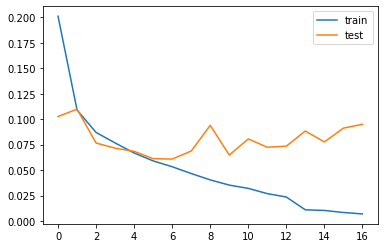

In [19]:
sns.lineplot(range(len(history['train_loss'])), history['train_loss'], label='train')
sns.lineplot(range(len(history['test_loss'])), history['test_loss'], label='test')

np.mean(history['test_loss'])

# История изменений значения метрики accuracy при обучении

0.9736401929574854

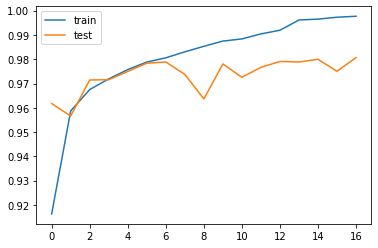

In [20]:
sns.lineplot(range(len(history['train_acc'])), [x.item() for x in history['train_acc']], label='train')
sns.lineplot(range(len(history['test_acc'])), [x.item() for x in history['test_acc']], label='test')

np.mean([x.item() for x in history['test_acc']])

# Отчет по другим метрикам

In [21]:
predictions = torch.zeros(1)
trues = torch.zeros(1)

for batch, labels in test_dataloader:    
    predictions = torch.cat((predictions.to(device), finish_model(batch.to(device)).argmax(dim=1)))
    trues = torch.cat((trues, labels))

In [22]:
print(classification_report(trues[1:], predictions[1:].cpu(), target_names=['female', 'male']))

              precision    recall  f1-score   support

      female       0.98      0.98      0.98      4990
        male       0.98      0.98      0.98      4994

    accuracy                           0.98      9984
   macro avg       0.98      0.98      0.98      9984
weighted avg       0.98      0.98      0.98      9984

